In [1]:
import pandas as pd
import numpy as np

from keras import Input
from keras.engine import Model
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.layers import Concatenate, concatenate, TimeDistributed, Flatten
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [2]:

# features is a list of strings of feature names 

def build_model(features, data_length):
    
    inputs_list = [] 
    for feature_name in features:
        inputs_list.append((Input(shape=(data_length,1), name=feature_name)))
    
    layers = [] 
    for i, input_name in enumerate(inputs_list): 
        layers.append(LSTM(32, return_sequences=True)(inputs_list[i]) )
        
    merged = concatenate(layers) 
    
    #main_output = Dense(32, activation='relu')(output)
    
    #output = TimeDistributed(Dense(3, activation='softmax', name='IsSpike'))(output)
    
    hidden1 = TimeDistributed(Dense(16, activation='relu'))(merged)
    
    flattened = Flatten()(hidden1) 
    
    output = Dense(3, activation='softmax', name='IsSpike')(flattened)
    
    
    model = Model(
        inputs = inputs_list,
        outputs = [output]
    )
    
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model    

data_length = 24


### Model Shape

* Price  ----------> LSTM --\
* Google Trends ---> LSTM ---> Dense Layer -> Softmax -> Output: Is Spike (1,0,-1) 
* Volume ----------> LSTM --/




* Input: Price, Google Trends, and Volume for time t0-t9 (10 hours of data) 
* Output: Is Spike (1,0,-1) for t10 
    * Using 10 hours (t0-t9) of Price, Google Trends, and Volume to predict the price movement at t11 (t10)

In [3]:
from sklearn.preprocessing import MinMaxScaler

master_df = pd.read_csv('C:/Users/Shoya/surf/data/master_df_v3.csv', encoding='latin1')
df = master_df[['Timestamp', 'Close', 'Volume_(BTC)', 'Volume_(Currency)', 'Date(UTC)', 'Bitcoin (Adj.Overlap)', 
               'Close Price % Change', 'Close Price % Change (Abs)', 'Is Spike']]


trends_df = pd.read_csv('C:/Users/Shoya/surf/data/Adj_Google_Trends_for_Mult_Keywords.csv', encoding='latin1') 
trends_cols = ["BitstampTrend", "CoinbaseTrend", "EthereumTrend", "BubbleTrend", "CryptocurrencyTrend", 
               "HashingTrend", "BlockchainTrend" ]


# lag inputs depending on data_length 
df['Price_lagged'] = df['Close']#.shift(data_length)
df['Volume_BTC'] = df['Volume_(BTC)']#.shift(data_length)
df['Bitcoin_Adj'] = df['Bitcoin (Adj.Overlap)']#.shift(data_length)

df[trends_cols] = trends_df[trends_cols]

df = df.dropna()


#cols = ['Volume_BTC','Bitcoin_Adj', 'Close', 'Price_lagged']
cols = [
 'Volume_BTC','Bitcoin_Adj', 'Close', 'Price_lagged',
 "BitstampTrend", "CoinbaseTrend", "BubbleTrend", "CryptocurrencyTrend", 
    "HashingTrend", "BlockchainTrend"    
]


# Stationalize Data by taking log differences
data_array = np.diff(np.log(df[cols]), axis=0)
df_2 = pd.DataFrame(data_array, columns=cols)
df_scaled = df_2.replace([np.inf, -np.inf], np.nan).dropna()
# Min-Max Scale 

scalers = {}
datas = [] 

#df_scaled = pd.DataFrame(columns=cols)


############################################################
#  Fix below - I am scaling the whole data set together, when I should scale the train and test datasets separately
############################################################

for i in range(len(cols)): 
    scalers[cols[i]] = MinMaxScaler()
    #print('data', data_array[:,i])
    
    col_data = data_array[:,i]
    
    col_data = pd.Series(col_data).replace([np.inf, -np.inf], np.nan).dropna().values
    
    col_data = np.reshape(col_data, (len(col_data), 1))
    
    data = scalers[cols[i]].fit_transform( col_data )
    #print('scaled', data)
    data = np.reshape(data, (1, len(data)))
    df_scaled[cols[i]] = pd.Series(data[0])

df_scaled['Is Spike'] = df['Is Spike']
df_scaled.dropna(inplace=True)
display(df_scaled.head())
display(df_scaled.tail())

C:\Users\Shoya\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Shoya\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Shoya\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.py

,Volume_BTC,Bitcoin_Adj,Close,Price_lagged,BitstampTrend,CoinbaseTrend,BubbleTrend,CryptocurrencyTrend,HashingTrend,BlockchainTrend,Is Spike
1,0.776791,0.471970,0.484557,0.484557,0.526899,0.605058,0.535584,0.527141,0.333716,0.576911,1.0
2,0.463316,0.439996,0.538331,0.538331,0.524515,0.551960,0.512201,0.501026,0.395838,0.520447,1.0
3,0.725079,0.529463,0.520715,0.520715,0.503101,0.578359,0.574125,0.500021,0.328380,0.515816,-1.0
4,0.210661,0.416611,0.566098,0.566098,0.481687,0.550792,0.535584,0.490725,0.401071,0.545998,0.0
5,0.594148,0.445509,0.568881,0.568881,0.503101,0.610758,0.535584,0.652792,0.284584,0.438642,-1.0


,Volume_BTC,Bitcoin_Adj,Close,Price_lagged,BitstampTrend,CoinbaseTrend,BubbleTrend,CryptocurrencyTrend,HashingTrend,BlockchainTrend,Is Spike
30197,0.511200,0.435052,0.528579,0.528579,0.498689,0.527715,0.473545,0.509784,0.371092,0.526187,-1.0
30198,0.478128,0.426471,0.560737,0.560737,0.498596,0.554062,0.519161,0.518383,0.375046,0.525074,-1.0
30199,0.496631,0.427146,0.526134,0.526134,0.451915,0.552787,0.483831,0.518284,0.261137,0.524087,1.0
30200,0.613268,0.453625,0.516569,0.516569,0.401379,0.572967,0.517432,0.509883,0.379883,0.473249,-1.0
30201,0.443013,0.453625,0.582366,0.582366,0.493590,0.599583,0.487998,0.514084,0.282666,0.536255,1.0


In [ ]:
from keras.utils.np_utils import to_categorical

# split and reshape data to feed into RNN

# for some reason, the more elegant dict approach on v2 notebook doesn't work so I will do this longer version

X_volume = df_scaled['Volume_BTC'].values
X_trends = df_scaled['Bitcoin_Adj'].values
X_lagged_price = df_scaled['Price_lagged'].values
X_trends_coinbase = df_scaled["CoinbaseTrend"].values
X_trends_blockchain = df_scaled["BlockchainTrend"].values
X_trends_bubble = df_scaled["BubbleTrend"].values

Y_is_spike = df_scaled['Is Spike'].values 

# train_size = int(len(X_volume) * 0.80)
# train_size = int(train_size/data_length) * data_length

test_size_index = int(len(X_volume)/data_length)*data_length

train_size = int(len(X_volume) * 0.80)
train_size = int(train_size/data_length) * data_length

X_train_volume = []
X_test_volume = [] 
X_train_trends = []
X_test_trends = []
X_train_trends_coinbase = [] 
X_test_trends_coinbase = [] 
X_train_trends_blockchain = []
X_test_trends_blockchain = []
X_train_trends_bubble = []
X_test_trends_bubble = []
X_train_lagged_price = []
X_test_lagged_price = []
Y_train_is_spike = [] 
Y_test_is_spike = [] 


for i in range(train_size-data_length):
    vol_temp = []
    trends_temp = []
    price_temp = []
    trends_coinbase_temp = [] 
    trends_blockchain_temp = []
    trends_bubble_temp = []
    for j in range(data_length):
        vol_temp.append(X_volume[i+j])
        trends_temp.append(X_trends[i+j])
        price_temp.append(X_lagged_price[i+j])
        trends_coinbase_temp.append(X_trends_coinbase[i+j])
        trends_blockchain_temp.append(X_trends_blockchain[i+j])
        trends_bubble_temp.append(X_trends_bubble[i+j])
    X_train_volume.append(vol_temp)
    X_train_trends.append(trends_temp)
    X_train_lagged_price.append(price_temp)
    X_train_trends_coinbase.append(trends_coinbase_temp)
    X_train_trends_blockchain.append(trends_blockchain_temp)
    X_train_trends_bubble.append(trends_bubble_temp)
    
    Y_train_is_spike.append(Y_is_spike[i+data_length])
    
for i in range(test_size_index-train_size-data_length):
    vol_temp = []
    trends_temp = [] 
    price_temp = [] 
    trends_coinbase_temp = [] 
    trends_blockchain_temp = []
    trends_bubble_temp = []
    for j in range(data_length):
        vol_temp.append(X_volume[train_size+i+j])
        trends_temp.append(X_trends[train_size+i+j])
        price_temp.append(X_lagged_price[train_size+i+j])
        trends_coinbase_temp.append(X_trends_coinbase[train_size+i+j])
        trends_blockchain_temp.append(X_trends_blockchain[train_size+i+j])
        trends_bubble_temp.append(X_trends_bubble[train_size+i+j])
    X_test_volume.append(vol_temp)
    X_test_trends.append(trends_temp)
    X_test_lagged_price.append(price_temp)
    X_test_trends_coinbase.append(trends_coinbase_temp)
    X_test_trends_blockchain.append(trends_blockchain_temp)
    X_test_trends_bubble.append(trends_bubble_temp)
    
    Y_test_is_spike.append(Y_is_spike[train_size+i+data_length])
    
X_train_volume = np.array(X_train_volume)
X_test_volume =  np.array(X_test_volume)
X_train_trends = np.array(X_train_trends)
X_test_trends = np.array(X_test_trends)
X_train_trends_coinbase = np.array(X_train_trends_coinbase)
X_test_trends_coinbase = np.array(X_test_trends_coinbase)
X_train_lagged_price = np.array(X_train_lagged_price)
X_test_lagged_price = np.array(X_test_lagged_price)
X_train_trends_blockchain = np.array(X_train_trends_blockchain)
X_test_trends_blockchain = np.array(X_test_trends_blockchain)
X_train_trends_bubble = np.array(X_train_trends_bubble)
X_test_trends_bubble = np.array(X_test_trends_bubble)
Y_train_is_spike =  np.array(Y_train_is_spike)
Y_test_is_spike = np.array(Y_test_is_spike)
    
    
Y_train_is_spike_onehot = to_categorical(Y_train_is_spike, num_classes=3)
Y_test_is_spike_onehot = to_categorical(Y_test_is_spike,num_classes=3)



X_train_volume = np.reshape(X_train_volume, (X_train_volume.shape[0],data_length,1) ) 
X_train_trends = np.reshape(X_train_trends, (X_train_trends.shape[0],data_length,1) ) 
X_train_trends_coinbase = np.reshape(X_train_trends_coinbase, (X_train_trends_coinbase.shape[0],data_length,1) ) 
X_train_lagged_price = np.reshape(X_train_lagged_price, (X_train_lagged_price.shape[0], data_length, 1))
X_train_trends_blockchain = np.reshape(X_train_trends_blockchain, (X_train_trends_blockchain.shape[0],data_length,1) )
X_train_trends_bubble = np.reshape(X_train_trends_bubble, (X_train_trends_bubble.shape[0],data_length,1) )


In [24]:
df_train_check = pd.DataFrame(X_train_lagged_price[0])
for i in range(1,len(X_train_lagged_price)):
    df_train_check[i] = X_train_lagged_price[i]

df_test_check = pd.DataFrame(X_test_lagged_price[0])

for i in range(1,len(X_test_lagged_price)):
    df_test_check[i] = X_test_lagged_price[i]

df_train_check.head()    
df_test_check.head()

,0,1,2,3,4,5,6,7,8,9,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
0,0.575119,0.557883,0.530973,0.519940,0.540369,0.552200,0.541641,0.537179,0.609281,0.544154,...,0.558755,0.541072,0.539979,0.539335,0.548901,0.538739,0.542131,0.549157,0.539638,0.536557
1,0.557883,0.530973,0.519940,0.540369,0.552200,0.541641,0.537179,0.609281,0.544154,0.524064,...,0.541072,0.539979,0.539335,0.548901,0.538739,0.542131,0.549157,0.539638,0.536557,0.554422
2,0.530973,0.519940,0.540369,0.552200,0.541641,0.537179,0.609281,0.544154,0.524064,0.565229,...,0.539979,0.539335,0.548901,0.538739,0.542131,0.549157,0.539638,0.536557,0.554422,0.547941
3,0.519940,0.540369,0.552200,0.541641,0.537179,0.609281,0.544154,0.524064,0.565229,0.575437,...,0.539335,0.548901,0.538739,0.542131,0.549157,0.539638,0.536557,0.554422,0.547941,0.539293
4,0.540369,0.552200,0.541641,0.537179,0.609281,0.544154,0.524064,0.565229,0.575437,0.524171,...,0.548901,0.538739,0.542131,0.549157,0.539638,0.536557,0.554422,0.547941,0.539293,0.547441


In [32]:
display(len(X_lagged_price))
display(len(X_train_lagged_price))
display(len(X_test_lagged_price))

30109

24048

6000

In [29]:
display(df_train_check.head())

writer = pd.ExcelWriter("checktrain.xlsx",  engine='xlsxwriter', options={'remove_timezone': True})
df_train_check.transpose().to_excel(writer)
writer.save()

writer2 = pd.ExcelWriter("checktest.xlsx",  engine='xlsxwriter', options={'remove_timezone': True})
df_test_check.transpose().to_excel(writer2)
writer2.save()


,0,1,2,3,4,5,6,7,8,9,...,24038,24039,24040,24041,24042,24043,24044,24045,24046,24047
0,0.484557,0.538331,0.520715,0.566098,0.568881,0.523904,0.520334,0.533277,0.463739,0.545460,...,0.578648,0.489107,0.574141,0.534550,0.550966,0.534130,0.567577,0.624524,0.527643,0.619001
1,0.538331,0.520715,0.566098,0.568881,0.523904,0.520334,0.533277,0.463739,0.545460,0.550962,...,0.489107,0.574141,0.534550,0.550966,0.534130,0.567577,0.624524,0.527643,0.619001,0.627446
2,0.520715,0.566098,0.568881,0.523904,0.520334,0.533277,0.463739,0.545460,0.550962,0.548729,...,0.574141,0.534550,0.550966,0.534130,0.567577,0.624524,0.527643,0.619001,0.627446,0.601662
3,0.566098,0.568881,0.523904,0.520334,0.533277,0.463739,0.545460,0.550962,0.548729,0.514868,...,0.534550,0.550966,0.534130,0.567577,0.624524,0.527643,0.619001,0.627446,0.601662,0.542777
4,0.568881,0.523904,0.520334,0.533277,0.463739,0.545460,0.550962,0.548729,0.514868,0.531067,...,0.550966,0.534130,0.567577,0.624524,0.527643,0.619001,0.627446,0.601662,0.542777,0.326392


In [17]:
X_test_volume = np.reshape(X_test_volume, (X_test_volume.shape[0],data_length,1) ) 
X_test_trends = np.reshape(X_test_trends, (X_test_trends.shape[0],data_length,1) )  
X_test_trends_coinbase = np.reshape(X_test_trends_coinbase, (X_test_trends_coinbase.shape[0],data_length,1) )  
X_test_lagged_price = np.reshape(X_test_lagged_price, (X_test_lagged_price.shape[0],data_length,1))
X_test_trends_blockchain = np.reshape(X_test_trends_blockchain, (X_test_trends_blockchain.shape[0],data_length,1) )
X_test_trends_bubble = np.reshape(X_test_trends_bubble, (X_test_trends_bubble.shape[0],data_length,1) )

In [5]:
#features = ['Volume_BTC', 'Price_lagged', 'CoinbaseTrend']
#features = ['Volume_BTC', 'Bitcoin_Adj', 'Price_lagged']
#features = ['Volume_BTC', 'Price_lagged']
key_features = [
    'Volume_BTC',
    'Bitcoin_Adj', 
    'Price_lagged', 
    'CoinbaseTrend',
    'BlockchainTrend',
    'BubbleTrend'
]
rnn = build_model(key_features, data_length) 

tensorboard_callback = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

history = rnn.fit(
    [
        X_train_volume,
        X_train_trends,
        X_train_lagged_price,
        X_train_trends_coinbase,
        X_train_trends_blockchain,
        X_train_trends_bubble
    ],
    [
        Y_train_is_spike_onehot
    ]
    ,
    validation_data=(
        [
            X_test_volume,
            X_test_trends,
            X_test_lagged_price,
            X_test_trends_coinbase,
            X_test_trends_blockchain,
            X_test_trends_bubble
        ],
        [
            Y_test_is_spike_onehot
        ]),
    epochs=100,
    batch_size=64,
    callbacks=[
      tensorboard_callback
    ],
    verbose=1
)

Train on 24048 samples, validate on 6000 samples
Epoch 1/100
24048/24048 [==============================] - 55s - loss: 1.0764 - categorical_accuracy: 0.4386 - val_loss: 1.1574 - val_categorical_accuracy: 0.2457
Epoch 2/100
24048/24048 [==============================] - 54s - loss: 1.0758 - categorical_accuracy: 0.4389 - val_loss: 1.1826 - val_categorical_accuracy: 0.2457
Epoch 3/100
24048/24048 [==============================] - 54s - loss: 1.0757 - categorical_accuracy: 0.4389 - val_loss: 1.1414 - val_categorical_accuracy: 0.2457
Epoch 4/100
24048/24048 [==============================] - 56s - loss: 1.0754 - categorical_accuracy: 0.4389 - val_loss: 1.1623 - val_categorical_accuracy: 0.2457
Epoch 5/100
24048/24048 [==============================] - 55s - loss: 1.0753 - categorical_accuracy: 0.4389 - val_loss: 1.1379 - val_categorical_accuracy: 0.2457
Epoch 6/100
24048/24048 [==============================] - 56s - loss: 1.0753 - categorical_accuracy: 0.4389 - val_loss: 1.1527 - val_ca

24048/24048 [==============================] - 81s - loss: 0.6901 - categorical_accuracy: 0.7019 - val_loss: 1.1268 - val_categorical_accuracy: 0.5687
Epoch 51/100
24048/24048 [==============================] - 79s - loss: 0.6823 - categorical_accuracy: 0.7097 - val_loss: 1.1209 - val_categorical_accuracy: 0.5675s: 0.6818 - catego
Epoch 52/100
24048/24048 [==============================] - 78s - loss: 0.6759 - categorical_accuracy: 0.7130 - val_loss: 1.1321 - val_categorical_accuracy: 0.5675
Epoch 53/100
24048/24048 [==============================] - 76s - loss: 0.6705 - categorical_accuracy: 0.7143 - val_loss: 1.1153 - val_categorical_accuracy: 0.5707
Epoch 54/100
24048/24048 [==============================] - 77s - loss: 0.6675 - categorical_accuracy: 0.7187 - val_loss: 1.1494 - val_categorical_accuracy: 0.5673
Epoch 55/100
24048/24048 [==============================] - 77s - loss: 0.6634 - categorical_accuracy: 0.7188 - val_loss: 1.1624 - val_categorical_accuracy: 0.5702
Epoch 56/10

24048/24048 [==============================] - 51s - loss: 0.4670 - categorical_accuracy: 0.8153 - val_loss: 2.0710 - val_categorical_accuracy: 0.5697
Epoch 100/100
24048/24048 [==============================] - 51s - loss: 0.4658 - categorical_accuracy: 0.8162 - val_loss: 1.9006 - val_categorical_accuracy: 0.5815


In [50]:
from keras.utils import plot_model
display(rnn.summary())
plot_model(rnn, to_file='model.png')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Volume_BTC (InputLayer)          (None, 24, 1)         0                                            
____________________________________________________________________________________________________
Price_lagged (InputLayer)        (None, 24, 1)         0                                            
____________________________________________________________________________________________________
CoinbaseTrend (InputLayer)       (None, 24, 1)         0                                            
____________________________________________________________________________________________________
lstm_25 (LSTM)                   (None, 24, 64)        16896       Volume_BTC[0][0]                 
___________________________________________________________________________________________

None

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

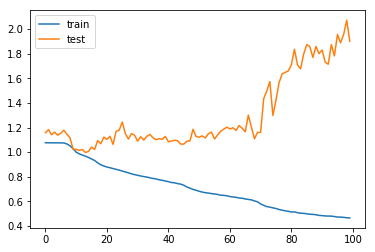

In [6]:
from matplotlib import pyplot as plt

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [7]:
score = rnn.evaluate(
    [
        X_test_volume,
            X_test_trends,
            X_test_lagged_price,
            X_test_trends_coinbase,
            X_test_trends_blockchain,
            X_test_trends_bubble
    ],
    [
        Y_test_is_spike_onehot
    ])

print('\n')
print("Accuracy: %.2f%%" % (score[1]*100))

5984/6000 [============================>.] - ETA: 0s

Accuracy: 58.15%


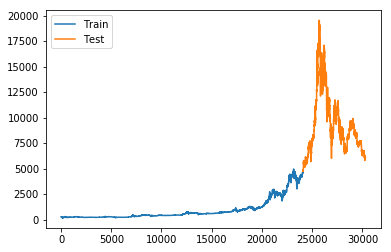

In [8]:
train_size = int(len(X_volume) * 0.8)
train_size = int(train_size/data_length) * data_length

# val_size = int(train_size * 0.95)
# val_size = int(val_size/data_length) * data_length

plt.plot(df['Close'].iloc[:train_size], label='Train')
#plt.plot(df['Close'].iloc[val_size:train_size], label='Validation')
plt.plot(df['Close'].iloc[train_size:], label='Test')
plt.legend()
plt.show();

# TODO: maybe move around so that validation is a little before peak to 24000 ish and test is a little before peak to end 

In [9]:
yhat = rnn.predict( 
    [
       X_test_volume,
            X_test_trends,
            X_test_lagged_price,
            X_test_trends_coinbase,
            X_test_trends_blockchain,
            X_test_trends_bubble
    ],
    verbose=0
)

display(yhat)

inverted_yhat = np.argmax(yhat,axis=1) #returns INDICES of max 
onehot_to_val_dict = {0: 0, 1: 1, 2:-1 }

inverted_yhat_arr = np.asarray(inverted_yhat)
predicted = [onehot_to_val_dict[i] for i in inverted_yhat_arr]


df_pred_output = pd.DataFrame(predicted, columns=['predicted'])
df_pred_output['actual'] = Y_test_is_spike
#df_pred_output['index_output'] = inverted_yhat
display(df_pred_output.head())

correct = (df_pred_output['actual'].values == df_pred_output['predicted'].values)
accuracy = correct.sum() / correct.size
display(accuracy)

array([[  3.97283398e-03,   8.76293634e-04,   9.95150805e-01],
       [  1.82084879e-03,   9.97898459e-01,   2.80565524e-04],
       [  9.25661743e-01,   5.68813570e-02,   1.74568370e-02],
       ..., 
       [  4.86131497e-02,   9.26806867e-01,   2.45799497e-02],
       [  9.52686787e-01,   2.87193060e-02,   1.85939316e-02],
       [  2.28503961e-02,   3.93280713e-03,   9.73216772e-01]], dtype=float32)

,predicted,actual
0,-1,-1.0
1,1,1.0
2,0,0.0
3,1,1.0
4,-1,-1.0


0.58150000000000002

In [33]:
writer = pd.ExcelWriter("checkresult.xlsx",  engine='xlsxwriter', options={'remove_timezone': True})
df_pred_output.to_excel(writer)
writer.save()

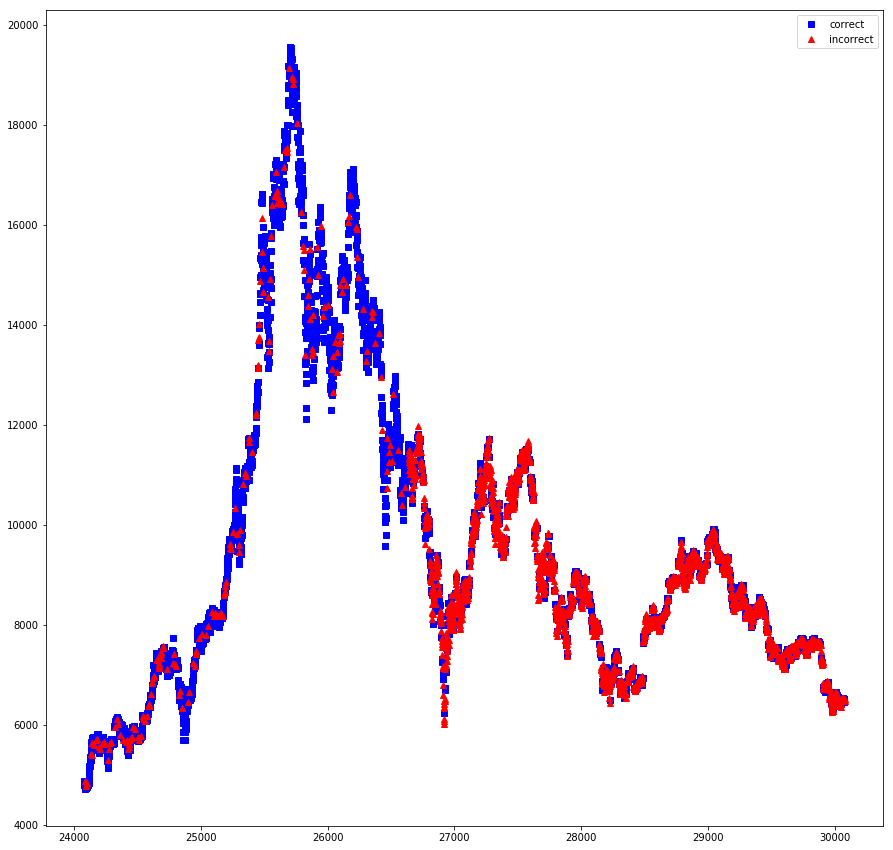

In [10]:
correct = (df_pred_output['actual'].values == df_pred_output['predicted'].values)
incorrect = (df_pred_output['actual'].values != df_pred_output['predicted'].values)

fig, ax = plt.subplots(figsize=(15,15))

ax.plot(df.iloc[train_size:].loc[correct, "Close"], 'bs', label='correct', )
ax.plot(df.iloc[train_size:].loc[incorrect, "Close"], 'r^', label='incorrect', )
plt.legend()
plt.show();

In [31]:
# serialize model to JSON# serial 
model_json = rnn.to_json()
with open("model_classification_v1data_200epochs_10length.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
rnn.save_weights("model_classification_v1data_200epochs_10length.h5")

In [93]:
from sklearn import metrics

#print(metrics.confusion_matrix(df_pred_output['actual'].values, df_pred_output['predicted'].values,labels=[0,1,-1]))

confusion_matrix = pd.crosstab(df_pred_output['actual'].values, df_pred_output['predicted'].values, rownames=['Actual'], colnames=['Predicted'], margins=True)

display(confusion_matrix)

Predicted,-1,0,1,All
Actual,,,,
-1.0,1443,342,481,2266
0.0,521,655,298,1474
1.0,666,391,1203,2260
All,2630,1388,1982,6000


In [40]:
# need to check what the rnn actually learned 
# visualize predicted vs actual to get insight into this 

# try with instead of just 10% biggest changes, maybe with 25% 
# is it just learning from the previous prices, or is google trends actually helping 
# -> run rnn without google trends 


# I have a master_df_v2 now so try that - this one has 0.3 as cutoff for is Spike 
# Have to eventually get validation data - also get overall newer more data 